In [1]:
import tensorflow as tf
import imageio
import natsort
import glob
import PIL
import IPython
import numpy as np
import matplotlib.pyplot as plt
from gan import Generator
from tensorflow_probability import distributions as tfd

## Create GIF from training images

In [2]:
files = natsort.natsorted(glob.glob("./train_images/*"))

gif = "infogan_mnist.gif"
with imageio.get_writer(gif, mode="I") as writer:
    last = -1
    for i, file in enumerate(files):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
            
        image = imageio.imread(file)
        writer.append_data(image)
        
IPython.display.Image(filename=gif)        

<IPython.core.display.Image object>

## Restore Checkpoint

In [3]:
generator = Generator()
checkpoint = tf.train.Checkpoint(generator=generator)
checkpoint.restore("ckpt/ckpt-100")

In [4]:
def sample(z, size, cat=-1, c1=None, c2=None):
    if c1 is not None:
        z_con1 = np.array([c1] * size)
        z_con1 = np.reshape(z_con1, [size, 1])
    else:
        z_con1 = tfd.Uniform(low=-1.0, high=1.0).sample([size, 1])
        
    if c2 is not None:
        z_con2 = np.array([c2] * size)
        z_con2 = np.reshape(z_con2, [size, 1])
    else:
        z_con2 = tfd.Uniform(low=-1.0, high=1.0).sample([size, 1])
        
    if cat >= 0:
        z_cat = np.array([cat] * size)
        z_cat = tf.one_hot(z_cat, 10)
    else:
        z_cat = tfd.Categorical(probs=tf.ones([10])*0.1).sample([size,])
        z_cat = tf.one_hot(z_cat, 10)
    
    noise = tf.concat([z, z_con1, z_con2, z_cat], axis=-1)
    
    return noise

## Varying categorical variable

In [5]:
output_image = []
for i in range(10):
    z = tfd.Uniform(low=-1.0, high=1.0).sample([5, 62])
    noise = sample(z, 5, cat=i)
    imgs = generator(noise, training=False)
    imgs = (imgs + 1.) / 2.
    
    imgs = np.split(imgs, 5, 0)
    imgs = [np.reshape(img, [28, 28]) for img in imgs]
    imgs = np.concatenate(imgs, 0)
    output_image.append(imgs)
    
output_image = np.concatenate(output_image, 1)
output_image.shape

(140, 280)

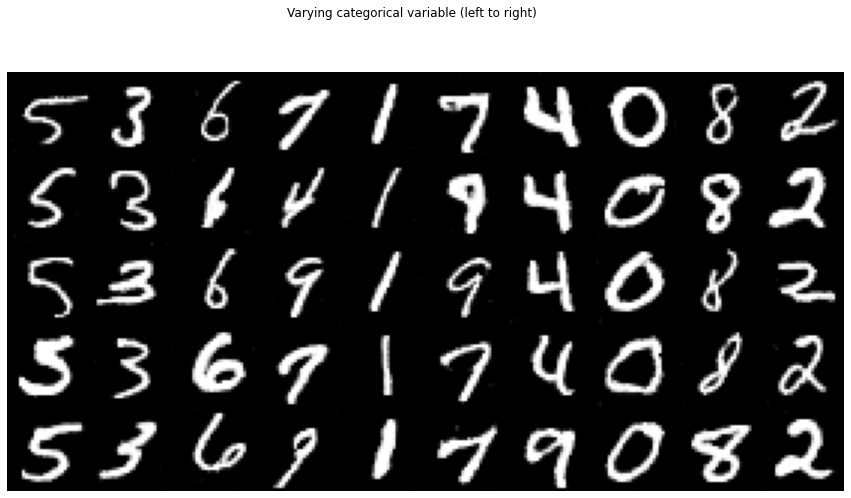

In [6]:
plt.figure(figsize=(15,8))
plt.suptitle("Varying categorical variable (left to right)")
plt.imshow(output_image, cmap="gray")
plt.axis("off")
plt.show()

## Varying first continuous variable

In [7]:
output_image = []
cc = np.linspace(-2.0, 2.0, 10)
z = tfd.Uniform(low=-1.0, high=1.0).sample([1, 62])
for i in range(5):
    imgs = []
    for ii in range(10):
        noise = sample(z, 1, cat=i, c1=cc[ii], c2=0.0)
        img = generator(noise, training=False)[0]
        img = (img + 1.) / 2.
        imgs.append(np.reshape(img, [28, 28]))
    imgs = np.concatenate(imgs, 1)
    output_image.append(imgs)
    
output_image = np.concatenate(output_image, 0)
output_image.shape    

(140, 280)

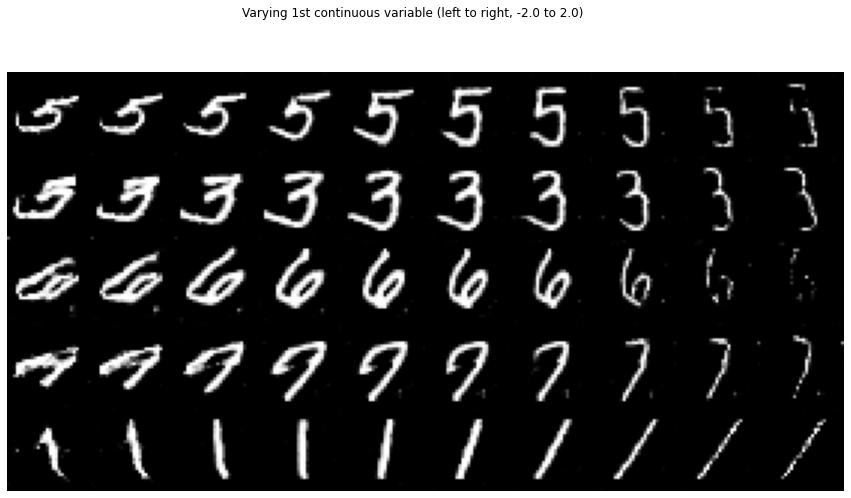

In [8]:
plt.figure(figsize=(15,8))
plt.suptitle("Varying 1st continuous variable (left to right, -2.0 to 2.0)")
plt.imshow(output_image, cmap="gray")
plt.axis("off")
plt.show()

## Varying second continuous variable

In [9]:
output_image = []
cc = np.linspace(-2.0, 2.0, 10)
z = tfd.Uniform(low=-1.0, high=1.0).sample([1, 62])
for i in range(5):
    imgs = []
    for ii in range(10):
        noise = sample(z, 1, cat=i, c1=-1.0, c2=cc[ii])
        img = generator(noise, training=False)[0]
        img = (img + 1.) / 2.
        imgs.append(np.reshape(img, [28, 28]))
    imgs = np.concatenate(imgs, 1)
    output_image.append(imgs)
    
output_image = np.concatenate(output_image, 0)
output_image.shape    

(140, 280)

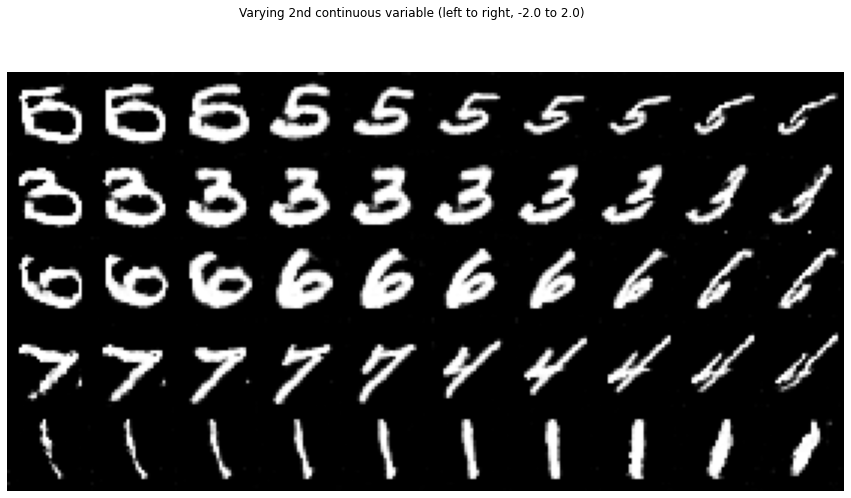

In [10]:
plt.figure(figsize=(15,8))
plt.suptitle("Varying 2nd continuous variable (left to right, -2.0 to 2.0)")
plt.imshow(output_image, cmap="gray")
plt.axis("off")
plt.show()

## Random Generation

In [11]:
z = tfd.Uniform(low=-1.0, high=1.0).sample([100, 62])
noise = sample(z, 100)
img = generator(noise, training=False)
img = (img + 1.) / 2.
img = tf.squeeze(img, axis=-1).numpy()

img.shape

(100, 28, 28)

In [12]:
img = np.split(img, 10, 0)
img = [np.concatenate(i, 0) for i in img]
img = np.concatenate(img, 1)
img.shape

(280, 280)

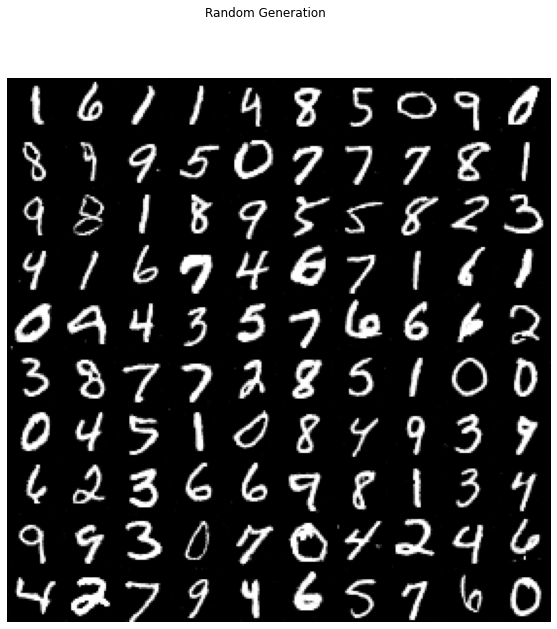

In [13]:
plt.figure(figsize=(15,10))
plt.suptitle("Random Generation")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()